In [2]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from torch.autograd import Variable

import numpy as np
import pandas as pd
from torch.utils.data import Dataset

## VAE model

In [3]:
class VAE(nn.Module):

    def __init__(self, embed_size):
        super(VAE, self).__init__()

        Z_dim = X_dim = h_dim = embed_size
        self.Z_dim = Z_dim
        self.X_dim= X_dim
        self.h_dim = h_dim
        self.embed_size= embed_size

        def init_weights(m):
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform(m.weight)
                if m.bias is not None:
                    nn.init.constant(m.bias, 0)

        # =============================== Q(z|X) ======================================
        self.dense_xh = nn.Linear(X_dim, h_dim)
        init_weights(self.dense_xh)

        self.dense_hz_mu = nn.Linear(h_dim, Z_dim)
        init_weights(self.dense_hz_mu)

        self.dense_hz_var = nn.Linear(h_dim, Z_dim)
        init_weights(self.dense_hz_var)

        # =============================== P(X|z) ======================================
        self.dense_zh = nn.Linear(Z_dim, h_dim)
        init_weights(self.dense_zh)

        self.dense_hx = nn.Linear(h_dim, X_dim)
        init_weights(self.dense_hx)

    def Q(self, X):
        h = nn.ReLU()(self.dense_xh(X))
        z_mu = self.dense_hz_mu(h)
        z_var = self.dense_hz_var(h)
        return z_mu, z_var

    def sample_z(self, mu, log_var):
        mb_size = mu.shape[0]
        eps = Variable(torch.randn(mb_size, self.Z_dim)).cuda()
        return mu + torch.exp(log_var / 2) * eps

    def P(self, z):
        h = nn.ReLU()(self.dense_zh(z))
        X = self.dense_hx(h)
        return X


## AGNN model

In [4]:
class AGNN(torch.nn.Module):
    def __init__(self, user_size, item_size, gender_size, age_size, occupation_size, genre_size, director_size, writer_size, star_size, country_size, embed_size, attention_size, dropout):
        super(AGNN, self).__init__()
        self.user_size = user_size
        self.item_size = item_size
        self.gender_size = gender_size
        self.age_size = age_size
        self.occupation_size = occupation_size
        self.genre_size = genre_size
        self.director_size = director_size
        self.writer_size = writer_size
        self.star_size = star_size
        self.country_size = country_size
        self.embed_size = embed_size
        self.dropout = dropout
        self.attention_size = attention_size

        def init_weights(m):
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform(m.weight)
                if m.bias is not None:
                    nn.init.constant(m.bias, 0)

        self.user_embed = torch.nn.Embedding(self.user_size, self.embed_size)
        self.item_embed = torch.nn.Embedding(self.item_size, self.embed_size)
        nn.init.xavier_uniform(self.user_embed.weight)
        nn.init.xavier_uniform(self.item_embed.weight)

        self.user_bias = torch.nn.Embedding(self.user_size, 1)
        self.item_bias = torch.nn.Embedding(self.item_size, 1)
        nn.init.constant(self.user_bias.weight, 0)
        nn.init.constant(self.item_bias.weight, 0)

        self.miu = torch.nn.Parameter(torch.zeros(1), requires_grad=True)

        self.gender_embed = torch.nn.Embedding(self.gender_size, self.embed_size)
        self.gender_embed.weight.data.normal_(0, 0.05)
        self.age_embed = torch.nn.Embedding(self.age_size, self.embed_size)
        self.age_embed.weight.data.normal_(0, 0.05)
        self.occupation_embed = torch.nn.Embedding(self.occupation_size, self.embed_size)
        self.occupation_embed.weight.data.normal_(0, 0.05)

        self.genre_embed = torch.nn.Embedding(self.genre_size, self.embed_size)
        self.genre_embed.weight.data.normal_(0, 0.05)
        self.director_embed = torch.nn.Embedding(self.director_size, self.embed_size)
        self.director_embed.weight.data.normal_(0, 0.05)
        self.writer_embed = torch.nn.Embedding(self.writer_size, self.embed_size)
        self.writer_embed.weight.data.normal_(0, 0.05)
        self.star_embed = torch.nn.Embedding(self.star_size, self.embed_size)
        self.star_embed.weight.data.normal_(0, 0.05)
        self.country_embed = torch.nn.Embedding(self.country_size, self.embed_size)
        self.country_embed.weight.data.normal_(0, 0.05)


        #--------------------------------------------------
        self.dense_item_self_biinter = nn.Linear(self.embed_size, self.embed_size)
        self.dense_item_self_siinter = nn.Linear(self.embed_size, self.embed_size)
        self.dense_item_onehop_biinter = nn.Linear(self.embed_size, self.embed_size)
        self.dense_item_onehop_siinter = nn.Linear(self.embed_size, self.embed_size)
        self.dense_user_self_biinter = nn.Linear(self.embed_size, self.embed_size)
        self.dense_user_self_siinter = nn.Linear(self.embed_size, self.embed_size)
        self.dense_user_onehop_biinter = nn.Linear(self.embed_size, self.embed_size)
        self.dense_user_onehop_siinter = nn.Linear(self.embed_size, self.embed_size)
        init_weights(self.dense_item_self_biinter)
        init_weights(self.dense_item_self_siinter)
        init_weights(self.dense_item_onehop_biinter)
        init_weights(self.dense_item_onehop_siinter)
        init_weights(self.dense_user_self_biinter)
        init_weights(self.dense_user_self_siinter)
        init_weights(self.dense_user_onehop_biinter)
        init_weights(self.dense_user_onehop_siinter)

        self.dense_item_cate_self = nn.Linear(2 * self.embed_size, self.embed_size)
        self.dense_item_cate_hop1 = nn.Linear(2 * self.embed_size, self.embed_size)
        self.dense_user_cate_self = nn.Linear(2 * self.embed_size, self.embed_size)
        self.dense_user_cate_hop1 = nn.Linear(2 * self.embed_size, self.embed_size)
        init_weights(self.dense_item_cate_self)
        init_weights(self.dense_item_cate_hop1)
        init_weights(self.dense_user_cate_self)
        init_weights(self.dense_user_cate_hop1)

        self.dense_item_addgate = nn.Linear(self.embed_size * 2, self.embed_size)
        init_weights(self.dense_item_addgate)
        self.dense_item_erasegate = nn.Linear(self.embed_size * 2, self.embed_size)
        init_weights(self.dense_item_erasegate)
        self.dense_user_addgate = nn.Linear(self.embed_size * 2, self.embed_size)
        init_weights(self.dense_user_addgate)
        self.dense_user_erasegate = nn.Linear(self.embed_size * 2, self.embed_size)

        self.user_vae = VAE(embed_size)
        self.item_vae = VAE(embed_size)

        #----------------------------------------------------
        #concat, mlp融合
        self.FC_pre = nn.Linear(2 * embed_size, 1)
        init_weights(self.FC_pre)

        """# dot
        self.user_bias = nn.Embedding(self.user_size, 1)
        self.item_bias = nn.Embedding(self.item_size, 1)
        self.user_bias.weight.data.normal_(0, 0.01)
        self.item_bias.weight.data.normal_(0, 0.01)
        self.bias = torch.nn.Parameter(torch.rand(1), requires_grad=True)
        self.bias.data.uniform_(0, 0.1)"""

        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
        self.leakyrelu = nn.LeakyReLU()
        self.dropout = nn.Dropout(p=0.2)

    def feat_interaction(self, feature_embedding, fun_bi, fun_si, dimension):
        summed_features_emb_square = (torch.sum(feature_embedding, dim=dimension)).pow(2)
        squared_sum_features_emb = torch.sum(feature_embedding.pow(2), dim=dimension)
        deep_fm = 0.5 * (summed_features_emb_square - squared_sum_features_emb)
        deep_fm = self.leakyrelu(fun_bi(deep_fm))
        bias_fm = self.leakyrelu(fun_si(feature_embedding.sum(dim=dimension)))
        nfm = deep_fm + bias_fm
        return nfm

    def forward(self, user, item, user_self_cate, user_onehop_id, user_onehop_cate, item_self_cate, item_self_director, item_self_writer, item_self_star, item_self_country, item_onehop_id, item_onehop_cate, item_onehop_director, item_onehop_writer, item_onehop_star, item_onehop_country, mode='train'):

        uids_list = user.cuda()
        sids_list = item.cuda()
        if mode == 'train' or mode == 'warm':
            user_embedding = self.user_embed(torch.autograd.Variable(uids_list))
            item_embedding = self.item_embed(torch.autograd.Variable(sids_list))
        if mode == 'ics':
            user_embedding = self.user_embed(torch.autograd.Variable(uids_list))
        if mode == 'ucs':
            item_embedding = self.item_embed(torch.autograd.Variable(sids_list))

        batch_size = item_self_cate.shape[0]
        cate_size = item_self_cate.shape[1]
        director_size = item_self_director.shape[1]
        writer_size = item_self_writer.shape[1]
        star_size = item_self_star.shape[1]
        country_size = item_self_country.shape[1]
        user_onehop_size = user_onehop_id.shape[1]
        item_onehop_size = item_onehop_id.shape[1]

        #------------------------------------------------------GCN-item
        # K=2
        item_onehop_id = self.item_embed(Variable(item_onehop_id))

        item_onehop_cate = self.genre_embed(Variable(item_onehop_cate).view(-1, cate_size)).view(batch_size,item_onehop_size,cate_size, -1)
        item_onehop_director = self.director_embed(Variable(item_onehop_director).view(-1, director_size)).view(batch_size, item_onehop_size, director_size, -1)
        item_onehop_writer = self.writer_embed(Variable(item_onehop_writer).view(-1, writer_size)).view(batch_size, item_onehop_size, writer_size, -1)
        item_onehop_star = self.star_embed(Variable(item_onehop_star).view(-1, star_size)).view(batch_size, item_onehop_size, star_size, -1)
        item_onehop_country = self.country_embed(Variable(item_onehop_country).view(-1, country_size)).view(batch_size, item_onehop_size, country_size, -1)

        item_onehop_feature = torch.cat([item_onehop_cate, item_onehop_director, item_onehop_writer, item_onehop_star, item_onehop_country], dim=2)
        item_onehop_embed = self.dense_item_cate_hop1(torch.cat([self.feat_interaction(item_onehop_feature, self.dense_item_onehop_biinter,  self.dense_item_onehop_siinter, dimension=2), item_onehop_id], dim=-1))

        # K=1
        item_self_cate = self.genre_embed(Variable(item_self_cate))
        item_self_director = self.director_embed(Variable(item_self_director))
        item_self_writer = self.writer_embed(Variable(item_self_writer))
        item_self_star = self.star_embed(Variable(item_self_star))
        item_self_country = self.country_embed(Variable(item_self_country))

        item_self_feature = torch.cat([item_self_cate, item_self_director, item_self_writer, item_self_star, item_self_country], dim=1)
        item_self_feature = self.feat_interaction(item_self_feature, self.dense_item_self_biinter, self.dense_item_self_siinter, dimension=1)

        if mode == 'ics':
            item_mu, item_var = self.item_vae.Q(item_self_feature)
            item_z = self.item_vae.sample_z(item_mu, item_var)
            item_embedding = self.item_vae.P(item_z)
        item_self_embed = self.dense_item_cate_self(torch.cat([item_self_feature, item_embedding], dim=-1))

        item_addgate = self.sigmoid(self.dense_item_addgate(torch.cat([item_self_embed.unsqueeze(1).repeat(1, item_onehop_size, 1), item_onehop_embed], dim=-1)))  # 商品的邻居门，控制邻居信息多少作为输入
        item_erasegate = self.sigmoid(self.dense_item_erasegate(torch.cat([item_self_embed, item_onehop_embed.mean(dim=1)], dim=-1)))
        item_onehop_embed_final = (item_onehop_embed * item_addgate).mean(1)
        item_self_embed = (1 - item_erasegate) * item_self_embed

        item_gcn_embed = self.leakyrelu(item_self_embed + item_onehop_embed_final)  # [batch, embed]

        #----------------------------------------------------------GCN-user
        # K=2
        user_onehop_id = self.user_embed(Variable(user_onehop_id))

        user_onehop_gender_emb = self.gender_embed(Variable(user_onehop_cate[:, :, 0]))
        user_onehop_age_emb = self.age_embed(Variable(user_onehop_cate[:, :, 1]))
        user_onehop_occupation_emb = self.occupation_embed(Variable(user_onehop_cate[:, :, 2]))

        user_onehop_feat = torch.cat([user_onehop_gender_emb.unsqueeze(2), user_onehop_age_emb.unsqueeze(2), user_onehop_occupation_emb.unsqueeze(2)], dim=2)
        user_onehop_embed = self.dense_user_cate_hop1(torch.cat([self.feat_interaction(user_onehop_feat, self.dense_user_onehop_biinter, self.dense_user_onehop_siinter, dimension=2), user_onehop_id], dim=-1))

        # K=1
        user_gender_emb = self.gender_embed(Variable(user_self_cate[:, 0]))
        user_age_emb = self.age_embed(Variable(user_self_cate[:, 1]))
        user_occupation_emb = self.occupation_embed(Variable(user_self_cate[:, 2]))

        user_self_feature = torch.cat([user_gender_emb.unsqueeze(1), user_age_emb.unsqueeze(1), user_occupation_emb.unsqueeze(1)], dim=1)
        user_self_feature = self.feat_interaction(user_self_feature, self.dense_user_self_biinter,  self.dense_user_onehop_siinter, dimension=1)

        if mode == 'ucs':
            user_mu, user_var = self.user_vae.Q(user_self_feature)
            user_z = self.user_vae.sample_z(user_mu, user_var)
            user_embedding = self.user_vae.P(user_z)
        user_self_embed = self.dense_user_cate_self(torch.cat([user_self_feature, user_embedding], dim=-1))

        user_addgate = self.sigmoid(self.dense_user_addgate(torch.cat([user_self_embed.unsqueeze(1).repeat(1, user_onehop_size, 1), user_onehop_embed],dim=-1)))
        user_erasegate = self.sigmoid(self.dense_user_erasegate(torch.cat([user_self_embed, user_onehop_embed.mean(dim=1)], dim=-1)))
        user_onehop_embed_final = (user_onehop_embed * user_addgate).mean(dim=1)
        user_self_embed = (1 - user_erasegate) * user_self_embed

        user_gcn_embed = self.leakyrelu(user_self_embed + user_onehop_embed_final)

        #--------------------------------------------------norm
        item_mu, item_var = self.item_vae.Q(item_self_feature)
        item_z = self.item_vae.sample_z(item_mu, item_var)
        item_preference_sample = self.item_vae.P(item_z)

        user_mu, user_var = self.user_vae.Q(user_self_feature)
        user_z = self.user_vae.sample_z(user_mu, user_var)
        user_preference_sample = self.user_vae.P(user_z)

        recon_loss = torch.norm(item_preference_sample - item_embedding) + torch.norm(user_preference_sample - user_embedding)
        kl_loss = torch.mean(0.5 * torch.sum(torch.exp(item_z) + item_mu ** 2 - 1. - item_var, 1)) + \
                  torch.mean(0.5 * torch.sum(torch.exp(user_z) + user_mu ** 2 - 1. - user_var, 1))

        ####################################prediction#####################################################

        #concat -> mlp
        bu = self.user_bias(Variable(uids_list))
        bi = self.item_bias(Variable(sids_list))
        #pred = (user_gcn_embed * item_gcn_embed).sum(1, keepdim=True) + bu + bi + (self.miu).repeat(batch_size, 1)
        tmp = torch.cat([user_gcn_embed, item_gcn_embed], dim=1)
        pred = self.FC_pre(tmp) + (user_gcn_embed * item_gcn_embed).sum(1, keepdim=True) + bu + bi + (self.miu).repeat(batch_size, 1)

        return pred.squeeze(), recon_loss, kl_loss


In [5]:
%pip install tensorboardX

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 3.2 MB/s eta 0:00:00


In [6]:
import os, time, argparse
import numpy as np
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tensorboardX import SummaryWriter
from collections import OrderedDict
import json
from torch.autograd import Variable

In [7]:
def get_data_list(ftrain, batch_size):
    f = open(ftrain, 'r')
    train_list = []
    for eachline in f:
        eachline = eachline.strip().split('\t')
        u, i, l = int(eachline[0]), int(eachline[1]), float(eachline[2])
        train_list.append([u, i, l])
    num_batches_per_epoch = int((len(train_list) - 1) / batch_size) + 1
    return num_batches_per_epoch, train_list

def get_batch_instances(train_list, user_feature_dict, item_feature_dict, item_director_dict, item_writer_dict, item_star_dict, item_country_dict, batch_size, user_nei_dict, item_nei_dict, shuffle=True):
    num_batches_per_epoch = int((len(train_list) - 1) / batch_size) + 1
    def data_generator(train_list):
        data_size = len(train_list)
        user_feature_arr = np.array(list(user_feature_dict.values()))
        max_user_cate_size = user_feature_arr.shape[1]

        item_genre_arr = np.array(list(item_feature_dict.values())) #len=6 ,0
        item_director_arr = np.array(list(item_director_dict.values())) #len=3 ,6
        item_writer_arr = np.array(list(item_writer_dict.values())) #len=3, 9
        item_star_arr = np.array(list(item_star_dict.values())) #len=3, 12
        item_country_arr = np.array(list(item_country_dict.values()))   #len=8, 15

        item_feature_arr = np.concatenate([item_genre_arr, item_director_arr, item_writer_arr, item_star_arr, item_country_arr], axis=1)
        max_item_cate_size = item_feature_arr.shape[1]

        item_layer1_nei_num = FLAGS.item_layer1_nei_num
        user_layer1_nei_num = FLAGS.user_layer1_nei_num

        if shuffle == True:
            np.random.shuffle(train_list)
        train_list = np.array(train_list)

        for batch_num in range(num_batches_per_epoch):
            start_index = batch_num * batch_size
            end_index = min((batch_num + 1) * batch_size, data_size)
            current_batch_size = end_index - start_index

            u = train_list[start_index: end_index][:, 0].astype(np.int64)
            i = train_list[start_index: end_index][:, 1].astype(np.int64)
            l = train_list[start_index: end_index][:, 2]

            i_self_cate = np.zeros([current_batch_size, max_item_cate_size], dtype=np.int64)
            i_onehop_id = np.zeros([current_batch_size, item_layer1_nei_num], dtype=np.int64)
            i_onehop_cate = np.zeros([current_batch_size, item_layer1_nei_num, max_item_cate_size], dtype=np.int64)

            u_self_cate = np.zeros([current_batch_size, max_user_cate_size], dtype=np.int64)
            u_onehop_id = np.zeros([current_batch_size, user_layer1_nei_num], dtype=np.int64)
            u_onehop_cate = np.zeros([current_batch_size, user_layer1_nei_num, max_user_cate_size], dtype=np.int64)

            for index, each_i in enumerate(i):
                i_self_cate[index] = item_feature_arr[each_i]    #item_self_cate

                tmp_one_nei = item_nei_dict[each_i][0]
                tmp_prob = item_nei_dict[each_i][1]
                if len(tmp_one_nei) > item_layer1_nei_num:  #re-sampling
                    tmp_one_nei = np.random.choice(tmp_one_nei, item_layer1_nei_num, replace=False, p=tmp_prob)
                elif len(tmp_one_nei) < item_layer1_nei_num:
                    tmp_one_nei = np.random.choice(tmp_one_nei, item_layer1_nei_num, replace=True, p=tmp_prob)
                tmp_one_nei[-1] = each_i

                i_onehop_id[index] = tmp_one_nei    #item_1_neigh
                i_onehop_cate[index] = item_feature_arr[tmp_one_nei]  #item_1_neigh_cate

            for index, each_u in enumerate(u):
                u_self_cate[index] = user_feature_dict[each_u]  # item_self_cate

                tmp_one_nei = user_nei_dict[each_u][0]
                tmp_prob = user_nei_dict[each_u][1]
                if len(tmp_one_nei) > user_layer1_nei_num:  # re-sampling
                    tmp_one_nei = np.random.choice(tmp_one_nei, user_layer1_nei_num, replace=False, p=tmp_prob)
                elif len(tmp_one_nei) < user_layer1_nei_num:
                    tmp_one_nei = np.random.choice(tmp_one_nei, user_layer1_nei_num, replace=True, p=tmp_prob)
                tmp_one_nei[-1] = each_u

                u_onehop_id[index] = tmp_one_nei  # user_1_neigh
                u_onehop_cate[index] = user_feature_arr[tmp_one_nei]  # user_1_neigh_cate

            yield ([u, i, l, u_self_cate, u_onehop_id, u_onehop_cate, i_self_cate, i_onehop_id, i_onehop_cate])
    return data_generator(train_list)


In [8]:
def metrics(model, test_dataloader):
    label_lst, pred_lst = [], []
    rmse, mse, mae = 0,0,0
    count = 0
    for batch_data in test_dataloader:
        user = torch.LongTensor(batch_data[0]).cuda()
        item = torch.LongTensor(batch_data[1]).cuda()
        label = torch.FloatTensor(batch_data[2]).cuda()
        user_self_cate = torch.LongTensor(batch_data[3]).cuda()
        user_onehop_id = torch.LongTensor(batch_data[4]).cuda()
        user_onehop_cate = torch.LongTensor(batch_data[5]).cuda()
        item_self_cate, item_self_director, item_self_writer, item_self_star, item_self_country = torch.LongTensor(
            batch_data[6])[:, 0:6].cuda(), torch.LongTensor(batch_data[6])[:, 6:9].cuda(), torch.LongTensor(
            batch_data[6])[:, 9:12].cuda(), torch.LongTensor(batch_data[6])[:, 12:15].cuda(), torch.LongTensor(
            batch_data[6])[:, 15:].cuda()
        item_onehop_id = torch.LongTensor(batch_data[7]).cuda()
        item_onehop_cate, item_onehop_director, item_onehop_writer, item_onehop_star, item_onehop_country = torch.LongTensor(
            batch_data[8])[:, :, 0:6].cuda(), torch.LongTensor(batch_data[8])[:, :, 6:9].cuda(), torch.LongTensor(
            batch_data[8])[:, :, 9:12].cuda(), torch.LongTensor(batch_data[8])[:, :, 12:15].cuda(), torch.LongTensor(
            batch_data[8])[:, :, 15:].cuda()

        prediction, recon_loss, kl_loss = model(user, item, user_self_cate, user_onehop_id, user_onehop_cate, item_self_cate,
                           item_self_director, item_self_writer, item_self_star, item_self_country, item_onehop_id,
                           item_onehop_cate, item_onehop_director, item_onehop_writer, item_onehop_star,
                           item_onehop_country, mode = mode)
        prediction = prediction.cpu().data.numpy()
        prediction = prediction.reshape(prediction.shape[0])
        label = label.cpu().numpy()
        my_rmse = np.sum((prediction - label) ** 2)
        my_mse = np.sum((prediction - label) ** 2)
        my_mae = np.sum(np.abs(prediction - label))
        # my_rmse = torch.sqrt(torch.sum((prediction - label) ** 2) / FLAGS.batch_size)
        rmse+=my_rmse
        mse+=my_mse
        mae+=my_mae
        count += len(user)
        label_lst.extend(list([float(l) for l in label]))
        pred_lst.extend(list([float(l) for l in prediction]))

    my_mse = mse/count
    my_rmse = np.sqrt(rmse/count)
    my_mae = mae/count
    return my_rmse, my_mse, my_mae, label_lst, pred_lst

In [9]:
"""
parser = argparse.ArgumentParser()
parser.add_argument("--lr", default=0.0005, type=float,
					help="learning rate.")
parser.add_argument("--dropout", default=0.5, type=float,
					help="dropout rate.")
parser.add_argument("--batch_size", default=128, type=int,
					help="batch size when training.")
parser.add_argument("--gpu", default="0", type=str,
					help="gpu card ID.")
parser.add_argument("--epochs", default=20, type=str,
					help="training epoches.")
parser.add_argument("--clip_norm", default=5.0, type=float,
					help="clip norm for preventing gradient exploding.")
parser.add_argument("--embed_size", default=30, type=int, help="embedding size for users and items.")
parser.add_argument("--attention_size", default=50, type=int, help="embedding size for users and items.")
parser.add_argument("--item_layer1_nei_num", default=10, type=int)
parser.add_argument("--user_layer1_nei_num", default=10, type=int)
parser.add_argument("--vae_lambda", default=1, type=int)
"""
class Flags:
  def __init__(self, lr, dropout, batch_size, gpu, epochs, clip_norm, embed_size, attention_size, item_layer1_nei_num, user_layer1_nei_num, vae_lambda):
    self.batch_size = batch_size
    self.lr = lr
    self.dropout = dropout
    self.gpu = gpu
    self.epochs = epochs
    self.clip_norm = clip_norm
    self.embed_size = embed_size
    self.attention_size = attention_size
    self.item_layer1_nei_num = item_layer1_nei_num
    self.user_layer1_nei_num = user_layer1_nei_num
    self.vae_lambda = vae_lambda

In [10]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [10]:
%ls drive/MyDrive/CS247/Project/ColdGAN

ColdGAN_github.ipynb    discriminator_1to2.pth  generator_1to2.pth  ml-1m/
ColdGAN.ipynb           dis.pth                 gen.pth             raw_gan_ratings.dat
ColdGAN_original.ipynb  gan_ratings.dat         ml-100k/


In [ ]:
coldgan_path = "drive/MyDrive/CS247/Project/ColdGAN/"
# dis_model = torch.load(coldgan_path+"dis.pth")
# gen_model = torch.load(coldgan_path+"gen.pth")

In [ ]:
gan_rating_df = pd.read_csv(coldgan_path + "gan_ratings.dat", sep=" ", header=None, names=["userId", "movieId", "rating"])
raw_gan_rating_df = pd.read_csv(coldgan_path + "raw_gan_ratings.dat", sep=" ", header=None, names=["userId", "movieId", "rating"])

In [ ]:
raw_gan_rating_df.head()

,userId,movieId,rating
0,1,6,1.271245
1,1,10,2.208628
2,1,12,2.585064
3,1,14,2.335970
4,1,17,1.770078


In [ ]:
gan_rating_df.head()

,userId,movieId,rating
0,1,12,4.187459
1,1,14,3.501820
2,1,23,3.653943
3,1,24,4.114318
4,1,33,2.601903


## item cold start train loop

In [11]:
FLAGS = Flags(lr=0.0005, dropout=0.5, batch_size=128, gpu=0,
              epochs=20, clip_norm=5.0, embed_size=40,
              attention_size=50, # not specified in paper so leave as argparse default
              item_layer1_nei_num=10, # use argparse default

              user_layer1_nei_num=10, # use argparse default
              vae_lambda=1)

In [ ]:
def train_loop():
    #item cold start
    f_info = '../ml100k/uiinfo.pkl'
    f_neighbor = '../ml100k/neighbor_aspect_extension_2_zscore_ics_uuii_0.20.pkl'
    f_train = '../ml100k/ics_train.dat'
    f_test = '../ml100k/ics_val.dat'
    f_model = '../ml100k/agnn_ics_'

    """# user cold start
    f_info = '../ml100k/uiinfo.pkl'
    f_neighbor = '../ml100k/neighbor_aspect_extension_2_zscore_ucs_uuii.pkl'
    f_train = '../ml100k/ucs_train.dat'
    f_test = '../ml100k/ucs_val.dat'
    f_model = '../ml100k/agnn_ucs_'
    mode = 'ucs'"""

    """# warm start
    f_info = '../ml100k/uiinfo.pkl'
    f_neighbor = '../ml100k/neighbor_aspect_extension_2_zscore_warm_uuii.pkl'
    f_train = '../ml100k/warm_train.dat'
    f_test = '../ml100k/warm_val.dat'
    f_model = '../ml100k/agnn_warm_'
    mode = 'warm'"""

    # use best hyperparameters from paper
    # see section 4.1.4 and 4.3 for description of how they got them

    print("\nParameters:")
    print(FLAGS)

    with open(f_neighbor, 'rb') as f:
        neighbor_dict = pickle.load(f)
    user_nei_dict = neighbor_dict['user_nei_dict']
    item_nei_dict = neighbor_dict['item_nei_dict']
    director_num = neighbor_dict['director_num']
    writer_num = neighbor_dict['writer_num']
    star_num = neighbor_dict['star_num']
    country_num = neighbor_dict['country_num']

    item_director_dict = neighbor_dict['item_director_dict']    #dict[i]=[x,x,x]
    item_writer_dict = neighbor_dict['item_writer_dict']        #dict[i]=[x,x,x]
    item_star_dict = neighbor_dict['item_star_dict']            #dict[i]=[x,x,x]
    item_country_dict = neighbor_dict['item_country_dict']      #dict[i]=[x,x,x,x,x,x,x,x]

    with open(f_info, 'rb') as f:
        item_info = pickle.load(f)
    user_num = item_info['user_num']
    item_num = item_info['item_num']
    gender_num = item_info['gender_num']
    age_num = item_info['age_num']
    occupation_num = item_info['occupation_num']
    genre_num = item_info['genre_num']
    user_feature_dict = item_info['user_feature_dict']  #gender, age, occupation    dict[u]=[x,x,x]
    item_feature_dict = item_info['item_feature_dict']  #genre                      dict[i]=[x,x,x,x,x,x]

    print("user_num {}, item_num {}, gender_num {}, age_num {}, occupation_num {}, genre_num {}, director_num {}, writer_num {}, star_num {}, country_num {}, mode {} ".format(user_num, item_num, gender_num, age_num, occupation_num, genre_num, director_num, writer_num, star_num, country_num, mode))
    # idea: add interactions with GAN
    # gan_data: userId moveId rating
    # access all ratings of userId 1 via gan_rating_df[gan_rating_df["userId"] == 1]

    train_steps, train_list = get_data_list(f_train, batch_size=FLAGS.batch_size)
    test_steps, test_list = get_data_list(f_test, batch_size=FLAGS.batch_size)

    model = AGNN(user_num, item_num, gender_num, age_num, occupation_num, genre_num, director_num, writer_num, star_num, country_num, FLAGS.embed_size, FLAGS.attention_size, FLAGS.dropout)
    model.cuda()

    loss_function = torch.nn.MSELoss(size_average=False)
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=FLAGS.lr, weight_decay=0.001)

    writer = SummaryWriter()  # For visualization
    #f_loss_curve = open('tmp_loss_curve.txt', 'w')
    best_rmse = 5

    count = 0
    for epoch in range(FLAGS.epochs):
        #tmp_main_loss, tmp_vae_loss = [], []
        model.train()  # Enable dropout (if have).
        start_time = time.time()
        train_dataloader = get_batch_instances(train_list, user_feature_dict, item_feature_dict, item_director_dict, item_writer_dict, item_star_dict, item_country_dict,  batch_size=FLAGS.batch_size, user_nei_dict=user_nei_dict, item_nei_dict=item_nei_dict, shuffle=True)

        for idx, batch_data in enumerate(train_dataloader): #u, i, l, u_self_cate, u_onehop_id, u_onehop_rating, u_onehop_cate, i_self_cate, i_onehop_id, i_onehop_cate
            user = torch.LongTensor(batch_data[0]).cuda()
            item = torch.LongTensor(batch_data[1]).cuda()
            label = torch.FloatTensor(batch_data[2]).cuda()
            user_self_cate = torch.LongTensor(batch_data[3]).cuda()
            user_onehop_id = torch.LongTensor(batch_data[4]).cuda()
            user_onehop_cate = torch.LongTensor(batch_data[5]).cuda()
            item_self_cate, item_self_director, item_self_writer, item_self_star, item_self_country = torch.LongTensor(batch_data[6])[:, 0:6].cuda(), torch.LongTensor(batch_data[6])[:, 6:9].cuda(), torch.LongTensor(batch_data[6])[:, 9:12].cuda(), torch.LongTensor(batch_data[6])[:, 12:15].cuda(), torch.LongTensor(batch_data[6])[:, 15:].cuda()
            item_onehop_id = torch.LongTensor(batch_data[7]).cuda()
            item_onehop_cate, item_onehop_director, item_onehop_writer, item_onehop_star, item_onehop_country = torch.LongTensor(batch_data[8])[:, :, 0:6].cuda(), torch.LongTensor(batch_data[8])[:, :, 6:9].cuda(), torch.LongTensor(batch_data[8])[:, :, 9:12].cuda(), torch.LongTensor(batch_data[8])[:, :, 12:15].cuda(), torch.LongTensor(batch_data[8])[:, :, 15:].cuda()

            model.zero_grad()
            prediction, recon_loss, kl_loss = model(user, item, user_self_cate, user_onehop_id, user_onehop_cate, item_self_cate, item_self_director, item_self_writer, item_self_star, item_self_country, item_onehop_id, item_onehop_cate, item_onehop_director, item_onehop_writer, item_onehop_star, item_onehop_country, mode='train')

            label = Variable(label)

            main_loss = loss_function(prediction, label)
            loss = main_loss + FLAGS.vae_lambda * (recon_loss + kl_loss)

            loss.backward()
            # nn.utils.clip_grad_norm(model.parameters(), FLAGS.clip_norm)
            optimizer.step()
            writer.add_scalar('data/loss', loss.data, count)
            count += 1

        tmploss = torch.sqrt(loss / FLAGS.batch_size)
        print(50 * '#')
        print('epoch: ', epoch, '     ', tmploss.detach())

        model.eval()
        print('time = ', time.time() - start_time)
        test_dataloader = get_batch_instances(test_list, user_feature_dict, item_feature_dict, item_director_dict, item_writer_dict, item_star_dict, item_country_dict, batch_size=FLAGS.batch_size, user_nei_dict=user_nei_dict, item_nei_dict=item_nei_dict, shuffle=False)
        rmse, mse, mae, label_lst, pred_lst = metrics(model, test_dataloader)
        print('test rmse,mse,mae: ', rmse,mse,mae)

        """if (rmse < best_rmse):
            best_rmse = rmse
            f_name = f_model + str(best_rmse)[:7] + '.dat' #f_model + str(best_rmse)[:7] + '.dat'
            #torch.save(model, f_name)
            f = open(f_name, 'w')
            res_dict = {}
            res_dict['label'] = label_lst
            res_dict['pred'] = pred_lst
            json.dump(res_dict, f)
            f.close()
            print('save result ok')"""

## item cold start evaluation

In [ ]:
mode = 'ics'
train_loop()


Parameters:
user_num 944, item_num 1683, gender_num 2, age_num 7, occupation_num 21, genre_num 19, director_num 1112, writer_num 2016, star_num 2568, country_num 128, mode ics 


<ipython-input-3-d63240c34650>:26: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(self.user_embed.weight)
<ipython-input-3-d63240c34650>:27: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(self.item_embed.weight)
<ipython-input-3-d63240c34650>:31: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(self.user_bias.weight, 0)
<ipython-input-3-d63240c34650>:32: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(self.item_bias.weight, 0)
<ipython-input-3-d63240c34650>:20: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(m.weight)
<ipython-input-3-d63240c34650>:22: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.bias, 0)
<ipython-input-2-58aca48512

##################################################
epoch:  0       tensor(0.4547, device='cuda:0')
time =  25.63979172706604
test rmse,mse,mae:  1.0551795103140864 1.1134037989866754 0.8650801264458984
##################################################
epoch:  1       tensor(0.6400, device='cuda:0')
time =  25.227171182632446
test rmse,mse,mae:  1.0375909193411104 1.0765949158991308 0.8425302760576113
##################################################
epoch:  2       tensor(0.5679, device='cuda:0')
time =  26.013632774353027
test rmse,mse,mae:  1.0407498787481817 1.083160310114355 0.8477820615290809
##################################################
epoch:  3       tensor(0.5838, device='cuda:0')
time =  26.210723400115967
test rmse,mse,mae:  1.033925381668952 1.069001694859288 0.8414785545739618
##################################################
epoch:  4       tensor(0.4834, device='cuda:0')
time =  25.66456913948059
test rmse,mse,mae:  1.024149763025222 1.0488827371046185 0.82671051

## combine ColdGAN data into training data for user cold start

In [ ]:
%ls "drive/MyDrive/CS247/Project/AttributeGNN/ml100k"

ics_train.dat                                         runs/              uiinfo.pkl
ics_val.dat                                           source_data/       warm_train.dat
neighbor_aspect_extension_2_zscore_ics_uuii_0.20.pkl  ucs_train.dat      warm_val.dat
neighbor_aspect_extension_2_zscore_ucs_uuii.pkl       ucs_train_gan.dat
neighbor_aspect_extension_2_zscore_warm_uuii.pkl      ucs_val.dat


In [12]:
%cd drive/MyDrive/CS247/Project/AttributeGNN/ml100k

/content/drive/MyDrive/CS247/Project/AttributeGNN/ml100k


In [13]:
# ucs means user cold start
f_train_with_gan = "ucs_train_gan.dat"
f_train_with_gan_random = "ucs_train_random_gan.dat"
f_train_raw_lower_range_gan = "ucs_train_raw_gan_lower_range.dat"
f_train_gan_dcn = "ucs_train_gan_dcn.dat"
f_train_gan_dcn_greater_than_2_half = "ucs_train_gan_dcn_greater_than_2_half.dat"
f_train_raw_between_1_half_and_4_half_range_gan = "ucs_train_raw_gan_between_1.5_and_4.5_range.dat"
f_train_raw_between_1_half_and_4_half_range_gan_500_movies = "ucs_train_raw_gan_between_1.5_and_4.5_range_500_movies.dat"

In [14]:
ucs_train_df = pd.read_csv("ucs_train.dat", sep="\t",
                           header=None, names=["userId", "movieId", "rating"], index_col="userId").reset_index()

In [ ]:
import matplotlib.pyplot as plt

(array([ 4837.,     0.,  9249.,     0.,     0., 22021.,     0., 27114.,
            0., 16196.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

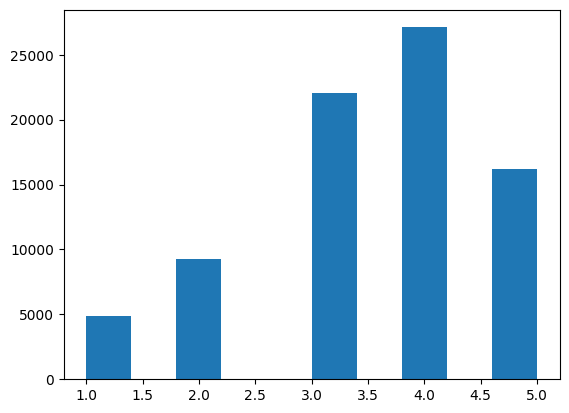

In [ ]:
plt.hist(ucs_train_df["rating"])

In [15]:
# TODO: restrict to lower rating range or higher range
#       or maybe randomly select some and add them
agnn_path = "drive/MyDrive/CS247/Project/AttributeGNN/"
ucs_train_df = pd.read_csv("ucs_train.dat", sep="\t",
                           header=None, names=["userId", "movieId", "rating"],
                           index_col="userId").reset_index()

gan_rating_dcn_df = pd.read_csv("gan_ratings_dcn.dat", sep=" ",
                                header=None, names=["userId", "movieId", "rating"],
                                index_col="userId").reset_index()
user_num = 944
movie_num = 1683
# TODO: try more users/movies
random_users = np.random.randint(low=1, high=user_num, size=100)
random_movies = np.random.randint(low=1, high=movie_num, size=300)
train_with_gan_df = pd.DataFrame(ucs_train_df)
iter_cnt = 0
train_with_gan_data = gan_rating_dcn_df[(gan_rating_dcn_df["rating"] > 2.5)]#  & (raw_gan_rating_df["rating"] < 4.5)]
for user_id in random_users:
  train_user_id_df = ucs_train_df[ucs_train_df["userId"] == user_id]
  gan_user_id_df = train_with_gan_data[train_with_gan_data["userId"] == user_id]
  print(iter_cnt)
  iter_cnt += 1
  # iterate through train_user_movies to see which ones have already rated
  # if not rated then use GAN rating
  for movie_id in random_movies:
    # if user has not rated movie
    if not train_user_id_df[train_user_id_df["movieId"] == movie_id].any().all():
      rating = gan_user_id_df[gan_user_id_df['movieId'] == movie_id]["rating"]
      if rating.empty:
        continue
      new_df = pd.DataFrame({"userId": user_id, "movieId": movie_id, "rating": rating})
      train_with_gan_df = pd.concat([train_with_gan_df, new_df])

# print(train_with_gan_df[train_with_gan_df["userId"] == 1])
# print(train_with_gan_df[((train_with_gan_df["userId"] == 1) & (train_with_gan_df["movieId"] == 273))])
# print(ucs_train_df[((ucs_train_df["userId"] == 1) & (ucs_train_df["movieId"] == 273))])
# gan_rating_df
train_with_gan_df.to_csv(f_train_gan_dcn_greater_than_2_half, sep="\t", header=False, index=False)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [ ]:
train_with_gan_df.head()

,userId,movieId,rating
0,1,1,5.0
1,1,2,3.0
2,1,3,4.0
3,1,4,3.0
4,1,5,3.0


In [15]:
len(ucs_train_df)

79417

In [16]:
len(train_with_gan_df)

173348

In [ ]:
ucs_train_df["userId"].max()

943

In [ ]:
gan_rating_df["userId"].max()

942

In [ ]:
gan_rating_df["movieId"].max()

1680

In [ ]:
# check users 1 through 4
numMovies_ml100k = 1683
train_with_gan_df[train_with_gan_df["movieId"] > 1683]

,userId,movieId,rating


## user cold start train loop

In [16]:
rmse_user_cold, mse_user_cold, mae_user_cold = [], [], []

In [ ]:
rmse_user_cold_no_gan, mse_user_cold_no_gan, mae_user_cold_no_gan = [], [], []

In [17]:
def user_cold_start_train_loop():
    #item cold start
    """
    f_info = '../ml100k/uiinfo.pkl'
    f_neighbor = '../ml100k/neighbor_aspect_extension_2_zscore_ics_uuii_0.20.pkl'
    f_train = '../ml100k/ics_train.dat'
    f_test = '../ml100k/ics_val.dat'
    f_model = '../ml100k/agnn_ics_'
    """

    # user cold start
    f_info = '../ml100k/uiinfo.pkl'
    f_neighbor = '../ml100k/neighbor_aspect_extension_2_zscore_ucs_uuii.pkl'
    # f_train_raw_lower_range_gan # f_train_with_gan_random # '../ml100k/ucs_train.dat' # f_train_with_gan
    f_train =  f_train_gan_dcn_greater_than_2_half # f_train_gan_dcn # f_train_raw_between_1_half_and_4_half_range_gan_500_movies # f_train_raw_between_1_half_and_4_half_range_gan
    f_test = '../ml100k/ucs_val.dat'
    f_model = '../ml100k/agnn_ucs_'

    """# warm start
    f_info = '../ml100k/uiinfo.pkl'
    f_neighbor = '../ml100k/neighbor_aspect_extension_2_zscore_warm_uuii.pkl'
    f_train = '../ml100k/warm_train.dat'
    f_test = '../ml100k/warm_val.dat'
    f_model = '../ml100k/agnn_warm_'
    mode = 'warm'"""

    # use best hyperparameters from paper
    # see section 4.1.4 and 4.3 for description of how they got them

    print("\nParameters:")
    print(FLAGS)

    with open(f_neighbor, 'rb') as f:
        neighbor_dict = pickle.load(f)
    user_nei_dict = neighbor_dict['user_nei_dict']
    item_nei_dict = neighbor_dict['item_nei_dict']
    director_num = neighbor_dict['director_num']
    writer_num = neighbor_dict['writer_num']
    star_num = neighbor_dict['star_num']
    country_num = neighbor_dict['country_num']

    item_director_dict = neighbor_dict['item_director_dict']    #dict[i]=[x,x,x]
    item_writer_dict = neighbor_dict['item_writer_dict']        #dict[i]=[x,x,x]
    item_star_dict = neighbor_dict['item_star_dict']            #dict[i]=[x,x,x]
    item_country_dict = neighbor_dict['item_country_dict']      #dict[i]=[x,x,x,x,x,x,x,x]

    with open(f_info, 'rb') as f:
        item_info = pickle.load(f)
    user_num = item_info['user_num']
    item_num = item_info['item_num']
    gender_num = item_info['gender_num']
    age_num = item_info['age_num']
    occupation_num = item_info['occupation_num']
    genre_num = item_info['genre_num']
    user_feature_dict = item_info['user_feature_dict']  #gender, age, occupation    dict[u]=[x,x,x]
    item_feature_dict = item_info['item_feature_dict']  #genre                      dict[i]=[x,x,x,x,x,x]

    print("user_num {}, item_num {}, gender_num {}, age_num {}, occupation_num {}, genre_num {}, director_num {}, writer_num {}, star_num {}, country_num {}, mode {} ".format(user_num, item_num, gender_num, age_num, occupation_num, genre_num, director_num, writer_num, star_num, country_num, mode))


    train_steps, train_list = get_data_list(f_train, batch_size=FLAGS.batch_size)
    test_steps, test_list = get_data_list(f_test, batch_size=FLAGS.batch_size)

    model = AGNN(user_num, item_num, gender_num, age_num, occupation_num, genre_num, director_num, writer_num, star_num, country_num, FLAGS.embed_size, FLAGS.attention_size, FLAGS.dropout)
    model.cuda()

    loss_function = torch.nn.MSELoss(size_average=False)
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=FLAGS.lr, weight_decay=0.001)

    writer = SummaryWriter()  # For visualization
    #f_loss_curve = open('tmp_loss_curve.txt', 'w')
    best_rmse = 5

    count = 0
    for epoch in range(FLAGS.epochs):
        #tmp_main_loss, tmp_vae_loss = [], []
        model.train()  # Enable dropout (if have).
        start_time = time.time()
        train_dataloader = get_batch_instances(train_list, user_feature_dict, item_feature_dict, item_director_dict, item_writer_dict, item_star_dict, item_country_dict,  batch_size=FLAGS.batch_size, user_nei_dict=user_nei_dict, item_nei_dict=item_nei_dict, shuffle=True)
        for idx, batch_data in enumerate(train_dataloader): #u, i, l, u_self_cate, u_onehop_id, u_onehop_rating, u_onehop_cate, i_self_cate, i_onehop_id, i_onehop_cate
            user = torch.LongTensor(batch_data[0]).cuda()
            item = torch.LongTensor(batch_data[1]).cuda()
            label = torch.FloatTensor(batch_data[2]).cuda()
            user_self_cate = torch.LongTensor(batch_data[3]).cuda()
            user_onehop_id = torch.LongTensor(batch_data[4]).cuda()
            user_onehop_cate = torch.LongTensor(batch_data[5]).cuda()
            item_self_cate, item_self_director, item_self_writer, item_self_star, item_self_country = torch.LongTensor(batch_data[6])[:, 0:6].cuda(), torch.LongTensor(batch_data[6])[:, 6:9].cuda(), torch.LongTensor(batch_data[6])[:, 9:12].cuda(), torch.LongTensor(batch_data[6])[:, 12:15].cuda(), torch.LongTensor(batch_data[6])[:, 15:].cuda()
            item_onehop_id = torch.LongTensor(batch_data[7]).cuda()
            item_onehop_cate, item_onehop_director, item_onehop_writer, item_onehop_star, item_onehop_country = torch.LongTensor(batch_data[8])[:, :, 0:6].cuda(), torch.LongTensor(batch_data[8])[:, :, 6:9].cuda(), torch.LongTensor(batch_data[8])[:, :, 9:12].cuda(), torch.LongTensor(batch_data[8])[:, :, 12:15].cuda(), torch.LongTensor(batch_data[8])[:, :, 15:].cuda()

            model.zero_grad()
            prediction, recon_loss, kl_loss = model(user, item, user_self_cate, user_onehop_id, user_onehop_cate, item_self_cate, item_self_director, item_self_writer, item_self_star, item_self_country, item_onehop_id, item_onehop_cate, item_onehop_director, item_onehop_writer, item_onehop_star, item_onehop_country, mode='train')

            label = Variable(label)

            main_loss = loss_function(prediction, label)
            loss = main_loss + FLAGS.vae_lambda * (recon_loss + kl_loss)

            loss.backward()
            # nn.utils.clip_grad_norm(model.parameters(), FLAGS.clip_norm)
            optimizer.step()
            writer.add_scalar('data/loss', loss.data, count)
            count += 1

        tmploss = torch.sqrt(loss / FLAGS.batch_size)
        print(50 * '#')
        print('epoch: ', epoch, '     ', tmploss.detach())

        model.eval()
        print('time = ', time.time() - start_time)
        test_dataloader = get_batch_instances(test_list, user_feature_dict, item_feature_dict, item_director_dict, item_writer_dict, item_star_dict, item_country_dict, batch_size=FLAGS.batch_size, user_nei_dict=user_nei_dict, item_nei_dict=item_nei_dict, shuffle=False)
        rmse, mse, mae, label_lst, pred_lst = metrics(model, test_dataloader)
        rmse_user_cold.append(rmse)
        mse_user_cold.append(mse)
        mae_user_cold.append(mae)
        print('test rmse,mse,mae: ', rmse,mse,mae)

        """if (rmse < best_rmse):
            best_rmse = rmse
            f_name = f_model + str(best_rmse)[:7] + '.dat' #f_model + str(best_rmse)[:7] + '.dat'
            #torch.save(model, f_name)
            f = open(f_name, 'w')
            res_dict = {}
            res_dict['label'] = label_lst
            res_dict['pred'] = pred_lst
            json.dump(res_dict, f)
            f.close()
            print('save result ok')"""

## user cold start evaluation

In [18]:
mode = 'ucs'
user_cold_start_train_loop()


Parameters:
user_num 944, item_num 1683, gender_num 2, age_num 7, occupation_num 21, genre_num 19, director_num 1112, writer_num 2016, star_num 2568, country_num 128, mode ucs 


<ipython-input-4-d63240c34650>:26: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(self.user_embed.weight)
<ipython-input-4-d63240c34650>:27: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(self.item_embed.weight)
<ipython-input-4-d63240c34650>:31: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(self.user_bias.weight, 0)
<ipython-input-4-d63240c34650>:32: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(self.item_bias.weight, 0)
<ipython-input-4-d63240c34650>:20: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(m.weight)
<ipython-input-4-d63240c34650>:22: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.bias, 0)
<ipython-input-3-58aca48512

##################################################
epoch:  0       tensor(0.6307, device='cuda:0')
time =  32.27700090408325
test rmse,mse,mae:  1.0376020696898998 1.0766180550247635 0.8401454044652102
##################################################
epoch:  1       tensor(0.7965, device='cuda:0')
time =  32.44855809211731
test rmse,mse,mae:  1.0340072169663008 1.069170924738395 0.8359014702649458
##################################################
epoch:  2       tensor(0.7466, device='cuda:0')
time =  29.50494146347046
test rmse,mse,mae:  1.0314579036906448 1.0639054070858995 0.8336864690683804
##################################################
epoch:  3       tensor(0.6738, device='cuda:0')
time =  28.97374939918518
test rmse,mse,mae:  1.028676074816141 1.0581744668991429 0.8307851596690126
##################################################
epoch:  4       tensor(0.6870, device='cuda:0')
time =  30.651841163635254
test rmse,mse,mae:  1.0285714525218197 1.057959232942846 0.823150983

In [23]:
rmse_user_cold[4]

1.0285714525218197

In [22]:
min(rmse_user_cold)

1.0285714525218197

In [19]:
print(f"rmse = {rmse_user_cold}")
print(f"mse = {mse_user_cold}")
print(f"mae = {mae_user_cold}")

rmse = [1.0376020696898998, 1.0340072169663008, 1.0314579036906448, 1.028676074816141, 1.0285714525218197, 1.054714245518273, 1.0362490126066124, 1.0458528444006725, 1.0513142313466217, 1.0526383432332844, 1.030290760190103, 1.0348774933604192, 1.0666074775757228, 1.0409316236658834, 1.0670717801556193, 1.0443387235565154, 1.0670664466791102, 1.0480691572068421, 1.0743105269870363, 1.0580480507442147]
mse = [1.0766180550247635, 1.069170924738395, 1.0639054070858995, 1.0581744668991429, 1.057959232942846, 1.11242213969918, 1.073812016128179, 1.0938081721409771, 1.105261613031938, 1.108047481644914, 1.0614990505331003, 1.0709714262639445, 1.137651511220446, 1.0835386451476923, 1.1386421840044822, 1.090643369519652, 1.1386308016283824, 1.0984489582882604, 1.1541431083951639, 1.1194656776836325]
mae = [0.8401454044652102, 0.8359014702649458, 0.8336864690683804, 0.8307851596690126, 0.8231509835612454, 0.8637896983829572, 0.8391220648029377, 0.8527365594020722, 0.8588564146748264, 0.85907331

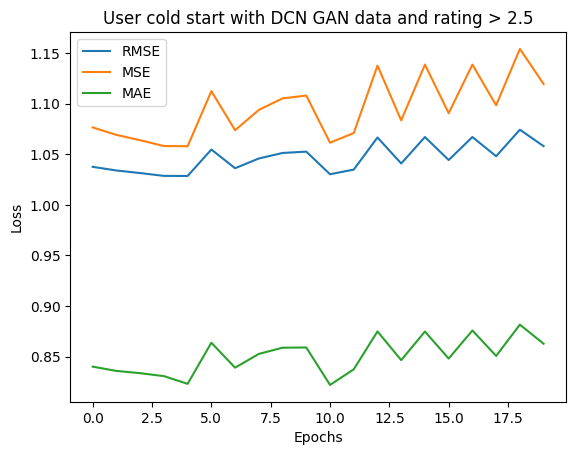

In [21]:
import matplotlib.pyplot as plt
plt.plot(np.arange(FLAGS.epochs), rmse_user_cold, label="RMSE")
plt.plot(np.arange(FLAGS.epochs), mse_user_cold, label="MSE")
plt.plot(np.arange(FLAGS.epochs), mae_user_cold, label="MAE")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("User cold start with DCN GAN data and rating > 2.5")
plt.legend()
plt.savefig("cold_start_with_random_selection_dcn_gan_greater_than_2_half_data.png")

In [ ]:
mode = 'ucs'
user_cold_start_train_loop()


Parameters:
user_num 944, item_num 1683, gender_num 2, age_num 7, occupation_num 21, genre_num 19, director_num 1112, writer_num 2016, star_num 2568, country_num 128, mode ucs 


<ipython-input-3-d63240c34650>:26: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(self.user_embed.weight)
<ipython-input-3-d63240c34650>:27: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(self.item_embed.weight)
<ipython-input-3-d63240c34650>:31: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(self.user_bias.weight, 0)
<ipython-input-3-d63240c34650>:32: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(self.item_bias.weight, 0)
<ipython-input-3-d63240c34650>:20: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(m.weight)
<ipython-input-3-d63240c34650>:22: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.bias, 0)
<ipython-input-2-58aca48512

##################################################
epoch:  0       tensor(0.6284, device='cuda:0')
time =  25.490104913711548
test rmse,mse,mae:  1.0405722006059397 1.082790504673888 0.8464080231568385
##################################################
epoch:  1       tensor(0.6078, device='cuda:0')
time =  25.36892557144165
test rmse,mse,mae:  1.0426457180761857 1.087110093422605 0.85364568944124
##################################################
epoch:  2       tensor(0.6554, device='cuda:0')
time =  25.339438438415527
test rmse,mse,mae:  1.054984067323406 1.112991382306237 0.8694136919389399
##################################################
epoch:  3       tensor(0.6325, device='cuda:0')
time =  25.421859979629517
test rmse,mse,mae:  1.0263775425101958 1.0534508597692689 0.8299921522542211
##################################################
epoch:  4       tensor(0.6416, device='cuda:0')
time =  25.36206579208374
test rmse,mse,mae:  1.0302911500877578 1.0614998539491547 0.8401793699

In [ ]:
print(rmse_user_cold_no_gan)
print(mse_user_cold_no_gan)
print(mae_user_cold_no_gan)

[1.0405722006059397, 1.0426457180761857, 1.054984067323406, 1.0263775425101958, 1.0302911500877578, 1.060191283911134, 1.048676119055913, 1.027149863447562, 1.0590905616707844, 1.0339745726309069, 1.0493876737500052, 1.0300842303152935, 1.0845629459272443, 1.0235729760404475, 1.0293496466432412, 1.0405810705270544, 1.0417006540918385, 1.043566367323451, 1.0721003372968343, 1.0349608543363196]
[1.082790504673888, 1.087110093422605, 1.112991382306237, 1.0534508597692689, 1.0614998539491547, 1.124005558481139, 1.0997216026781715, 1.0550368419803453, 1.1216728178201376, 1.0691034168472664, 1.1012144898184475, 1.0610735215442506, 1.1762767836783825, 1.0477016372802983, 1.0595606950445657, 1.0828089643392307, 1.0851402527353642, 1.0890307630086637, 1.149399133231986, 1.0711439700085643]
[0.8464080231568385, 0.85364568944124, 0.8694136919389399, 0.8299921522542211, 0.8401793699677355, 0.8706995597972425, 0.8593285801586393, 0.8312075081681485, 0.8709491228782789, 0.8382565942640202, 0.8560817

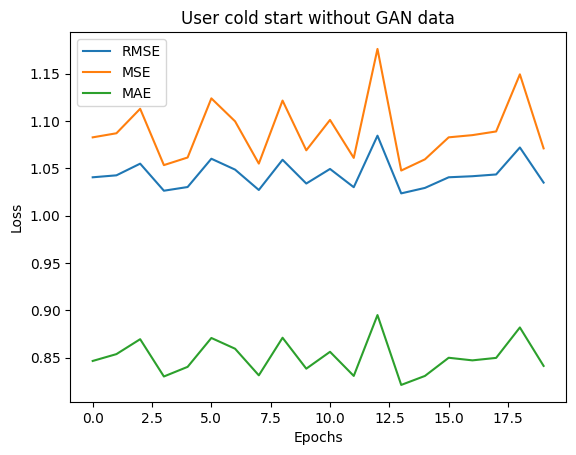

In [ ]:
import matplotlib.pyplot as plt
plt.plot(np.arange(FLAGS.epochs), rmse_user_cold_no_gan, label="RMSE")
plt.plot(np.arange(FLAGS.epochs), mse_user_cold_no_gan, label="MSE")
plt.plot(np.arange(FLAGS.epochs), mae_user_cold_no_gan, label="MAE")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("User cold start without GAN data")
plt.legend()
plt.savefig("cold_start_without_gan_data.png")

In [ ]:
mode = 'ucs'
user_cold_start_train_loop()


Parameters:
user_num 944, item_num 1683, gender_num 2, age_num 7, occupation_num 21, genre_num 19, director_num 1112, writer_num 2016, star_num 2568, country_num 128, mode ucs 


<ipython-input-3-d63240c34650>:26: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(self.user_embed.weight)
<ipython-input-3-d63240c34650>:27: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(self.item_embed.weight)
<ipython-input-3-d63240c34650>:31: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(self.user_bias.weight, 0)
<ipython-input-3-d63240c34650>:32: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(self.item_bias.weight, 0)
<ipython-input-3-d63240c34650>:20: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(m.weight)
<ipython-input-3-d63240c34650>:22: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.bias, 0)
<ipython-input-2-58aca48512

##################################################
epoch:  0       tensor(0.7474, device='cuda:0')
time =  24.88870096206665
test rmse,mse,mae:  1.049969338678701 1.1024356121653887 0.8612345195237062
##################################################
epoch:  1       tensor(0.6623, device='cuda:0')
time =  35.81278944015503
test rmse,mse,mae:  1.0392137655514728 1.0799652505116717 0.8486152374263131
##################################################
epoch:  2       tensor(0.6642, device='cuda:0')
time =  29.36483907699585
test rmse,mse,mae:  1.0311658194312443 1.0633029471633095 0.837472306369073
##################################################
epoch:  3       tensor(0.6220, device='cuda:0')
time =  24.726237058639526
test rmse,mse,mae:  1.0244357870825735 1.049468681855492 0.8253190897241172
##################################################
epoch:  4       tensor(0.5760, device='cuda:0')
time =  25.80716300010681
test rmse,mse,mae:  1.0209713729027456 1.0423825442869172 0.821111927

## warm start train loop

In [ ]:
def warm_start_train_loop():
    #item cold start
    """
    f_info = '../ml100k/uiinfo.pkl'
    f_neighbor = '../ml100k/neighbor_aspect_extension_2_zscore_ics_uuii_0.20.pkl'
    f_train = '../ml100k/ics_train.dat'
    f_test = '../ml100k/ics_val.dat'
    f_model = '../ml100k/agnn_ics_'

    # user cold start
    f_info = '../ml100k/uiinfo.pkl'
    f_neighbor = '../ml100k/neighbor_aspect_extension_2_zscore_ucs_uuii.pkl'
    f_train = '../ml100k/ucs_train.dat'
    f_test = '../ml100k/ucs_val.dat'
    f_model = '../ml100k/agnn_ucs_'
    """

    # warm start
    f_info = '../ml100k/uiinfo.pkl'
    f_neighbor = '../ml100k/neighbor_aspect_extension_2_zscore_warm_uuii.pkl'
    f_train = '../ml100k/warm_train.dat'
    f_test = '../ml100k/warm_val.dat'
    f_model = '../ml100k/agnn_warm_'

    # use best hyperparameters from paper
    # see section 4.1.4 and 4.3 for description of how they got them

    print("\nParameters:")
    print(FLAGS)

    with open(f_neighbor, 'rb') as f:
        neighbor_dict = pickle.load(f)
    user_nei_dict = neighbor_dict['user_nei_dict']
    item_nei_dict = neighbor_dict['item_nei_dict']
    director_num = neighbor_dict['director_num']
    writer_num = neighbor_dict['writer_num']
    star_num = neighbor_dict['star_num']
    country_num = neighbor_dict['country_num']

    item_director_dict = neighbor_dict['item_director_dict']    #dict[i]=[x,x,x]
    item_writer_dict = neighbor_dict['item_writer_dict']        #dict[i]=[x,x,x]
    item_star_dict = neighbor_dict['item_star_dict']            #dict[i]=[x,x,x]
    item_country_dict = neighbor_dict['item_country_dict']      #dict[i]=[x,x,x,x,x,x,x,x]

    with open(f_info, 'rb') as f:
        item_info = pickle.load(f)
    user_num = item_info['user_num']
    item_num = item_info['item_num']
    gender_num = item_info['gender_num']
    age_num = item_info['age_num']
    occupation_num = item_info['occupation_num']
    genre_num = item_info['genre_num']
    user_feature_dict = item_info['user_feature_dict']  #gender, age, occupation    dict[u]=[x,x,x]
    item_feature_dict = item_info['item_feature_dict']  #genre                      dict[i]=[x,x,x,x,x,x]

    print("user_num {}, item_num {}, gender_num {}, age_num {}, occupation_num {}, genre_num {}, director_num {}, writer_num {}, star_num {}, country_num {}, mode {} ".format(user_num, item_num, gender_num, age_num, occupation_num, genre_num, director_num, writer_num, star_num, country_num, mode))

    train_steps, train_list = get_data_list(f_train, batch_size=FLAGS.batch_size)
    test_steps, test_list = get_data_list(f_test, batch_size=FLAGS.batch_size)

    model = AGNN(user_num, item_num, gender_num, age_num, occupation_num, genre_num, director_num, writer_num, star_num, country_num, FLAGS.embed_size, FLAGS.attention_size, FLAGS.dropout)
    model.cuda()

    loss_function = torch.nn.MSELoss(size_average=False)
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=FLAGS.lr, weight_decay=0.001)

    writer = SummaryWriter()  # For visualization
    #f_loss_curve = open('tmp_loss_curve.txt', 'w')
    best_rmse = 5

    count = 0
    for epoch in range(FLAGS.epochs):
        #tmp_main_loss, tmp_vae_loss = [], []
        model.train()  # Enable dropout (if have).
        start_time = time.time()
        train_dataloader = get_batch_instances(train_list, user_feature_dict, item_feature_dict, item_director_dict, item_writer_dict, item_star_dict, item_country_dict,  batch_size=FLAGS.batch_size, user_nei_dict=user_nei_dict, item_nei_dict=item_nei_dict, shuffle=True)

        for idx, batch_data in enumerate(train_dataloader): #u, i, l, u_self_cate, u_onehop_id, u_onehop_rating, u_onehop_cate, i_self_cate, i_onehop_id, i_onehop_cate
            user = torch.LongTensor(batch_data[0]).cuda()
            item = torch.LongTensor(batch_data[1]).cuda()
            label = torch.FloatTensor(batch_data[2]).cuda()
            user_self_cate = torch.LongTensor(batch_data[3]).cuda()
            user_onehop_id = torch.LongTensor(batch_data[4]).cuda()
            user_onehop_cate = torch.LongTensor(batch_data[5]).cuda()
            item_self_cate, item_self_director, item_self_writer, item_self_star, item_self_country = torch.LongTensor(batch_data[6])[:, 0:6].cuda(), torch.LongTensor(batch_data[6])[:, 6:9].cuda(), torch.LongTensor(batch_data[6])[:, 9:12].cuda(), torch.LongTensor(batch_data[6])[:, 12:15].cuda(), torch.LongTensor(batch_data[6])[:, 15:].cuda()
            item_onehop_id = torch.LongTensor(batch_data[7]).cuda()
            item_onehop_cate, item_onehop_director, item_onehop_writer, item_onehop_star, item_onehop_country = torch.LongTensor(batch_data[8])[:, :, 0:6].cuda(), torch.LongTensor(batch_data[8])[:, :, 6:9].cuda(), torch.LongTensor(batch_data[8])[:, :, 9:12].cuda(), torch.LongTensor(batch_data[8])[:, :, 12:15].cuda(), torch.LongTensor(batch_data[8])[:, :, 15:].cuda()

            model.zero_grad()
            prediction, recon_loss, kl_loss = model(user, item, user_self_cate, user_onehop_id, user_onehop_cate, item_self_cate, item_self_director, item_self_writer, item_self_star, item_self_country, item_onehop_id, item_onehop_cate, item_onehop_director, item_onehop_writer, item_onehop_star, item_onehop_country, mode='train')

            label = Variable(label)

            main_loss = loss_function(prediction, label)
            loss = main_loss + FLAGS.vae_lambda * (recon_loss + kl_loss)

            loss.backward()
            # nn.utils.clip_grad_norm(model.parameters(), FLAGS.clip_norm)
            optimizer.step()
            writer.add_scalar('data/loss', loss.data, count)
            count += 1

        tmploss = torch.sqrt(loss / FLAGS.batch_size)
        print(50 * '#')
        print('epoch: ', epoch, '     ', tmploss.detach())

        model.eval()
        print('time = ', time.time() - start_time)
        test_dataloader = get_batch_instances(test_list, user_feature_dict, item_feature_dict, item_director_dict, item_writer_dict, item_star_dict, item_country_dict, batch_size=FLAGS.batch_size, user_nei_dict=user_nei_dict, item_nei_dict=item_nei_dict, shuffle=False)
        rmse, mse, mae, label_lst, pred_lst = metrics(model, test_dataloader)
        print('test rmse,mse,mae: ', rmse,mse,mae)

        """if (rmse < best_rmse):
            best_rmse = rmse
            f_name = f_model + str(best_rmse)[:7] + '.dat' #f_model + str(best_rmse)[:7] + '.dat'
            #torch.save(model, f_name)
            f = open(f_name, 'w')
            res_dict = {}
            res_dict['label'] = label_lst
            res_dict['pred'] = pred_lst
            json.dump(res_dict, f)
            f.close()
            print('save result ok')"""

## warm start evaluation

In [ ]:
mode = 'warm'
warm_start_train_loop()


Parameters:
user_num 944, item_num 1683, gender_num 2, age_num 7, occupation_num 21, genre_num 19, director_num 1112, writer_num 2016, star_num 2568, country_num 128, mode warm 


<ipython-input-3-d63240c34650>:26: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(self.user_embed.weight)
<ipython-input-3-d63240c34650>:27: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(self.item_embed.weight)
<ipython-input-3-d63240c34650>:31: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(self.user_bias.weight, 0)
<ipython-input-3-d63240c34650>:32: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(self.item_bias.weight, 0)
<ipython-input-3-d63240c34650>:20: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(m.weight)
<ipython-input-3-d63240c34650>:22: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.bias, 0)
<ipython-input-2-58aca48512

##################################################
epoch:  0       tensor(1.0151, device='cuda:0')
time =  23.46168541908264
test rmse,mse,mae:  0.9589199948953548 0.9195275566101074 0.763196667766571
##################################################
epoch:  1       tensor(1.0216, device='cuda:0')
time =  22.789565086364746
test rmse,mse,mae:  0.9589669293279343 0.9196175715446472 0.7543844308853149
##################################################
epoch:  2       tensor(0.9419, device='cuda:0')
time =  23.35577702522278
test rmse,mse,mae:  0.949622653104155 0.9017831832885742 0.7553976072311401
##################################################
epoch:  3       tensor(1.0448, device='cuda:0')
time =  24.511520862579346
test rmse,mse,mae:  0.9470426108694202 0.8968897068023681 0.7575070610046387
##################################################
epoch:  4       tensor(0.8948, device='cuda:0')
time =  24.16345715522766
test rmse,mse,mae:  0.934200380166723 0.8727303503036499 0.73649755